### Computer vision for image classification

Problem Statement

After cleaning the dataset, work on the classification

The instances were drawn randomly from a database of 7 outdoor images. The images were hand-segmented to create a classification for every pixel.
Each instance is a 3 pixel x 3 pixel region (9 pixels).

Your task is to predict the probability that each 3x3 image region belongs to each of the seven classes (window, foliage, brickface, sky, grass, path, cement).

For each unique 3x3 region you should provide 7 probabilities with value between 0 and 1.

### import packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import sklearn as skl
import seaborn as sns


In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../cmu_data"))

['.ipynb_checkpoints', 'train.csv', 'clean_image.csv', 'sample_submission_fixed.csv', 'test.csv']


### import dataset

In [3]:
#import csv data and read it as a dataframe
image_test_df=pd.read_csv('../cmu_data/test.csv', sep=',')
image_train_df=pd.read_csv('../cmu_data/train.csv', sep=',')



## EDA

In [4]:
image_test_df.head(2)

,id,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
0,0,105,110,9,0.0,0.0,0.500000,0.122222,1.944444,2.374073,4.222222,4.333334,6.333334,2.000000,0.333333,6.333334,-6.666666,6.333334,0.708333,-1.539762
1,1,36,189,9,0.0,0.0,1.944444,2.462961,5.833334,21.588884,31.370370,28.444445,38.000000,27.666666,-8.777778,19.888890,-11.111111,38.000000,0.266302,-2.020345


In [5]:
image_train_df.head(2)

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN,CLASS
0,123.0,152.0,9,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,226.0,110.0,9,0.0,0.0,0.333333,0.088889,0.5,0.211111,1.666667,0.111111,4.444445,0.444444,-4.666666,8.333333,-3.666667,4.444445,0.977778,-2.155984,1


In [6]:
image_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 20 columns):
REGION-CENTROID-COL     210 non-null float64
REGION-CENTROID-ROW     210 non-null float64
REGION-PIXEL-COUNT      210 non-null int64
SHORT-LINE-DENSITY-5    210 non-null float64
SHORT-LINE-DENSITY-2    210 non-null float64
VEDGE-MEAN              210 non-null float64
VEDGE-SD                210 non-null float64
HEDGE-MEAN              210 non-null float64
HEDGE-SD                210 non-null float64
INTENSITY-MEAN          210 non-null float64
RAWRED-MEAN             210 non-null float64
RAWBLUE-MEAN            210 non-null float64
RAWGREEN-MEAN           210 non-null float64
EXRED-MEAN              210 non-null float64
EXBLUE-MEAN             210 non-null float64
EXGREEN-MEAN            210 non-null float64
VALUE-MEAN              210 non-null float64
SATURATION-MEAN         210 non-null float64
HUE-MEAN                210 non-null float64
CLASS                   210 non-null int64

In [7]:
image_train_df.shape

(210, 20)

In [8]:
# to change dtype use .astype() 
image_train_df['REGION-PIXEL-COUNT'] = image_train_df['REGION-PIXEL-COUNT'].astype(float)

### Clean datasets

In [9]:
image_train_df.isnull().values.any()

False

In [10]:
image_test_df[image_test_df.isnull().values.any(axis=1)]

,id,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN


### check for outliers on train dataframe

### IQR method

In [11]:
import numpy as np

def outliers_iqr(image_train_df):
    quartile_1, quartile_3 = np.percentile(image_class_df, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((image_train_df > upper_bound) | (image_train_df < lower_bound))

### z-score method

In [12]:
import numpy as np

def outliers_z_score(image_train_df):
    threshold = 3

    mean_y = np.mean(image_train_df)
    stdev_y = np.std(image_train_df)
    z_scores = [(y - mean_y) / stdev_y for y in image_train_df]
    return np.where(np.abs(z_scores) > threshold)

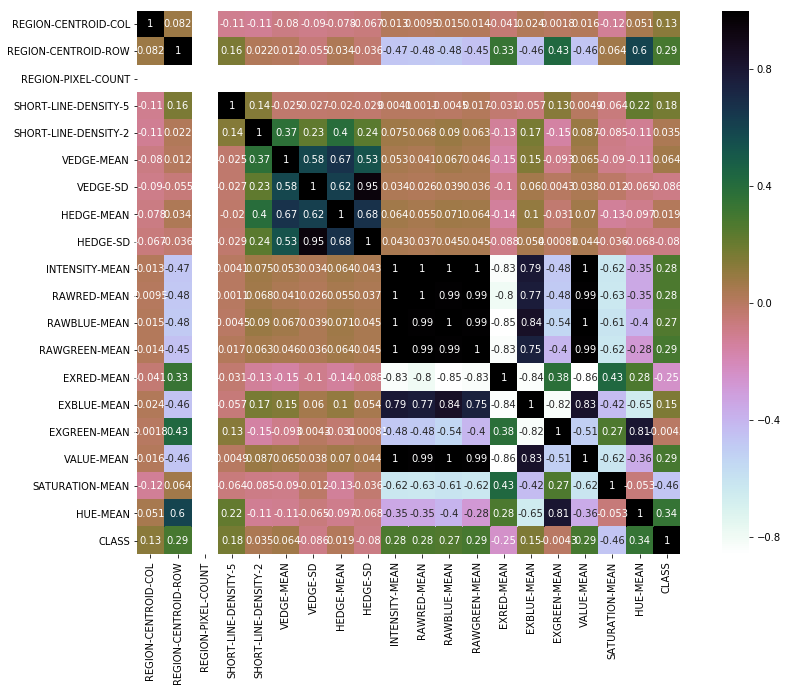

In [13]:
plt.figure(figsize=(15, 10))
sns.heatmap(image_train_df.corr(), vmax=1, annot=True, square=True, cmap='cubehelix_r')

## Boxplot

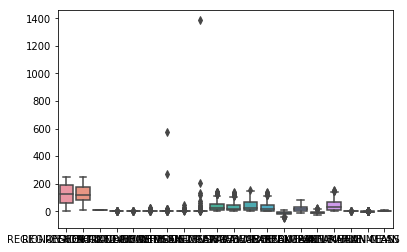

In [14]:
sns.boxplot(data=image_train_df)
plt.rcParams['figure.figsize'] = (30, 20)

### Plot Data

## Train and test 

### train and test split

In [15]:
image_train_df.keys()

Index(['REGION-CENTROID-COL', 'REGION-CENTROID-ROW', 'REGION-PIXEL-COUNT',
       'SHORT-LINE-DENSITY-5', 'SHORT-LINE-DENSITY-2', 'VEDGE-MEAN',
       'VEDGE-SD', 'HEDGE-MEAN', 'HEDGE-SD', 'INTENSITY-MEAN', 'RAWRED-MEAN',
       'RAWBLUE-MEAN', 'RAWGREEN-MEAN', 'EXRED-MEAN', 'EXBLUE-MEAN',
       'EXGREEN-MEAN', 'VALUE-MEAN', 'SATURATION-MEAN', 'HUE-MEAN', 'CLASS'],
      dtype='object')

In [16]:
image_test_df.keys()

Index(['id', 'REGION-CENTROID-COL', 'REGION-CENTROID-ROW',
       'REGION-PIXEL-COUNT', 'SHORT-LINE-DENSITY-5', 'SHORT-LINE-DENSITY-2',
       'VEDGE-MEAN', 'VEDGE-SD', 'HEDGE-MEAN', 'HEDGE-SD', 'INTENSITY-MEAN',
       'RAWRED-MEAN', 'RAWBLUE-MEAN', 'RAWGREEN-MEAN', 'EXRED-MEAN',
       'EXBLUE-MEAN', 'EXGREEN-MEAN', 'VALUE-MEAN', 'SATURATION-MEAN',
       'HUE-MEAN'],
      dtype='object')

In [17]:
# the classes 
image_train_df['CLASS'].unique()

array([0, 1, 2, 3, 4, 5, 6])

## Train-Test Data Splitting

In [ ]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

columns = ['REGION-CENTROID-COL', 'REGION-CENTROID-ROW', 'REGION-PIXEL-COUNT',
           'SHORT-LINE-DENSITY-5', 'SHORT-LINE-DENSITY-2', 'VEDGE-MEAN',
           'VEDGE-SD', 'HEDGE-MEAN', 'HEDGE-SD', 'INTENSITY-MEAN', 'RAWRED-MEAN',
       'RAWBLUE-MEAN', 'RAWGREEN-MEAN', 'EXRED-MEAN', 'EXBLUE-MEAN',
       'EXGREEN-MEAN', 'VALUE-MEAN', 'SATURATION-MEAN', 'HUE-MEAN']

holdout = image_test_df # from now on we will refer to this
               # dataframe as the holdout data
X = image_train_df[columns]
y = image_train_df['CLASS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=0)


### Prediction of the instances with a given 3*3 pixel region

## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
 #Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=800, max_depth=10, min_samples_split=2, 
                             min_samples_leaf=4,max_features='sqrt', bootstrap=True,random_state=42)
rfc.fit(X_train, y_train)


In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = LabelEncoder()
y_train_labels_fit = labels.fit(y_train)
y_train_lables_trf = labels.transform(y_train)

x_test = holdout.drop(['id'], axis=1)
holdout_predictions = rfc.predict_proba(x_test)

# model accuracy for X_test   
accuracy = rfc.score(X_test, y_test) 
print (accuracy)

In [ ]:
test_pred = pd.DataFrame(rfc.predict_proba(x_test)*1, columns=labels.classes_)
q = {'id': test_data["id"], 'no_financial_services': test_pred[0], 'other_only': test_pred[1],
    'mm_only': test_pred[2], 'mm_plus': test_pred[3]}
df_pred = pd.DataFrame(data=q)
df_pred = df_pred[['ID','no_financial_services', 'other_only', 'mm_only', 'mm_plus'  ]]

In [ ]:
rfc.score(X_train, y_train)

## XG BOOST

In [ ]:
#Applying XGBoost
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
xgb_clf = xgb_clf.fit(train_X, train_y)

print('The accuracy of the XGBoost classifier on training data is {:.2f}'.format(xgb_clf.score(train_X, train_y)))
print('The accuracy of the XGBoost classifier on test data is {:.2f}'.format(xgb_clf.score(test_X, test_y)))

In [ ]:
xgb = xgb.XGBClassifier()
model.fit(X, y)
holdout_predictions = model.predict(holdout[columns])

In [ ]:
holdout_ids = holdout["id"]
submission_df = {"id": holdout_ids,
                 "CLASS": holdout_predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission2.csv",index=False)